In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
from scipy.spatial import distance
import math
from scipy import interpolate

In [2]:
#Only this field needs to be altered per day
angle_deg = 226 #North angle of transect direction

# #########input 10_10_24#########
# #daily height fluctuations
# fluc_wells = [value / 100 for value in [20.4, 19.7, 19.9]] #height well above sand level

# transect_dist = [6.085, 8.928, 11.772, 14.643, 17.445, 20.418, 23.250, 26.143, 30.105, 33.402, 36.439, 40.095, 44.308] #distance from well 2
# transect_z = [-0.77, -0.985, -1.26, -1.58, -1.85, -2.12, -2.37, -2.61, -2.975, -3.295, -3.595, -3.935, -4.525]

#########input 09_11_24#########
fluc_wells = [value / 100 for value in [20.4, 19.7, 19.9]] #height well above sand level

transect_dist = [5.686, 7.781, 9.945, 12.236, 14.560, 17.112, 19.644, 22.819, 25.785, 28.677, 31.590, 34.292, 36.985, 39.766, 42.833, 44.308]
transect_z = [-0.775, -0.935, -1.050, -1.290, -1.520, -1.770, -2.015, -2.310, -2.535, -2.755, -2.995, -3.265, -3.520, -3.765, -4.085, -4.525]

# #########input 04_11_24#########
# fluc_wells = [value / 100 for value in [23.2, 19.4, 19.8]] #height well above sand level

# transect_dist = [3.353, 6.203, 9.049, 11.871, 14.757, 17.582, 20.509, 23.422, 26.228]
# transect_z = [-0.575, -0.812, -1.030, -1.230, -1.490, -1.700, -1.940, -2.150, -2.350]


In [3]:
#functions
def euclidean_distance(x1, y1, x2, y2):
    """Calculate Euclidean distance between two points (x1, y1) and (x2, y2)"""
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def angle_between_vectors(v1, v2):  
    v1 = np.array(v1)  
    v2 = np.array(v2)  
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))  
    angle = np.arccos(cos_theta)  # angle in radians  
    return np.degrees(angle)  # convert to degrees 

In [4]:
#well info
wellcoord = np.loadtxt('df_wells_UTM.txt', delimiter=',', usecols=(1, 2, 3))
wells_x, wells_y, wells_z = wellcoord.T  # Transpose for easy unpacking

#transect angle translation
angle_rad = np.radians(angle_deg)

#create UTM vector 228
V_228 = (np.sin(angle_rad), np.cos(angle_rad))
V_opp = (-np.cos(angle_rad), np.sin(angle_rad))

#because the 3 wells are not placed in a straight line, or in the same direction as the transect measurement direction, calculations below will be made, to project the well
#distances onto the transect direction ensuring that the height fluctuations are comparable

########################################################### well 1
#vector direction between well 1 and 2
V_12 = (wells_x[1] - wells_x[0], wells_y[1] - wells_y[0])

#anglewell12
angle_deg_1 = angle_between_vectors(V_228, V_12)
angle_deg_2 = angle_between_vectors(V_opp, V_12)
angle_rad_1, angle_rad_2 = np.radians(angle_deg_1), np.radians(angle_deg_2) #both angles in radians

#distance between well 1 and well 2
dist_well12 = euclidean_distance(wells_x[0], wells_y[0], wells_x[1], wells_y[1])

#projected distance compared to the transect direction for well 1 from well 2
b1 = (dist_well12 * np.sin(angle_rad_2)) / np.sin(np.radians(90))


########################################################### well 3
#vector between well 1 and 3
V_32 = (wells_x[1] - wells_x[2], wells_y[1] - wells_y[2])

#anglewell23
angle_deg_3 = angle_between_vectors(V_228, V_32)
angle_deg_22 = angle_between_vectors(V_opp, V_32)
angle_rad_3, angle_rad_2 = np.radians(angle_deg_3), np.radians(angle_deg_22) #both angles in radians

#distance between well 2 and 3
dist_well32 = euclidean_distance(wells_x[2], wells_y[2], wells_x[1], wells_y[1])

#projected distance compared to the transect direction for well 3 from well 2
b3 = (dist_well32 * np.sin(angle_rad_2)) / np.sin(np.radians(90))

In [5]:
#This code is for altering the local transect and interpolate, so that it can be used as the iz input for matlab CoastalCam

#########known#########
laserheight = 0.015
#well base
distance_wells = [0, b1, b1+b3] #projected distance from well 1 (either 228, or 226 degree North)

#########automatic part#########
#combine into one dist/z list
step1 = (transect_dist + distance_wells[1]) #distance from well 1
# Create new lists to store the combined data
dist = distance_wells.copy()  # Copy the original distance_wells list
dist.extend(step1)  # Add the calculated distances to the new dist list

# step2 = [z_well - fluc_well for z_well, fluc_well in zip(z_wells, fluc_wells)] #height correction for wells (list comprehension)
step3 = transect_z - (fluc_wells[1] + laserheight) * np.ones(len(transect_z))  # height correction for transect

step4 = wells_z - fluc_wells
step5 = step4 - step4[0]
step6 = (0 + step5[1] + fluc_wells[1] - laserheight) + transect_z

# Combine the height corrections into a single list
z = np.hstack((step5, step6))

# # print(step2)
# print()
# print(dist)
# print()
# print(z)
# # plot
# plt.plot(dist, z, marker='o')
# plt.ylim(-4, 0)
# plt.xlim(0, 30)
# plt.axis('equal')

In [6]:
print(f'int_end should end before {transect_dist[-1] + b1}')

int_end should end before 47.421311965988885


In [7]:
##interpolation
int_start = 0 #start from well 1
int_end = 48 #look at last fitting point for interpolation
idxdy = 2 #matlab input

x_interp = np.arange(int_start, int_end, idxdy)
linear_interp = interpolate.interp1d(dist, z, kind='linear')
z_interp = linear_interp(x_interp)

# # Plot the interpolated values
# plt.figure(figsize=(10, 6))
# plt.plot(dist, z, 'o', label='Measured transect')
# plt.plot(x_interp, z_interp, '-', label='Interpolated values')
# plt.xlabel('Distance (x) [m]')
# plt.ylabel('Height (z) [m]')
# plt.title('Linear Interpolation of Beach Profile')
# plt.legend()
# plt.grid(True)
# plt.show()

In [8]:
#extrapolation
ext_end = 80 + idxdy + 1 #depending on matlab input

#optimalization parameters (already optimized, don't change)
wherexis0 = 70
decay_rate = 0.02  # Controls how fast the slope decreases to 0

#####dont change anything below
ext_start = int_end + idxdy
x_extrap = np.arange(ext_start, ext_end, idxdy)

# # Slope from the last two known points
# slope_start = (z[-1] - z[-2]) / (dist[-1] - dist[-2])
# z_start = z[-1]

# # Smoothly decreasing slope to 0 using an exponential decay model
# def smooth_extrapolation(x, x0, z0, slope, x_end, decay_rate):
#     slope_factor = np.exp(-decay_rate * (x - x0))
#     return z0 + slope * (x - x0) * slope_factor

# # Parameters for smooth extrapolation

# z_extrap = smooth_extrapolation(x_extrap, dist[-1], z_start, slope_start, wherexis0, decay_rate)

# # Combine interpolated and extrapolated x and z values
# x_total = np.concatenate([x_interp, x_extrap])
# z_total = np.concatenate([z_interp, z_extrap])

# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(dist, z, 'o', label='Measured transect')
# plt.plot(x_total, z_total, '-', label='Interpolated & Smooth Extrapolated')
# # plt.axvline(wherexis0, color='r', linestyle='--', label='Slope=0 at x=78')
# plt.xlabel('Distance (x) [m]')
# plt.ylabel('Height (z) [m]')
# plt.title('Smooth Extrapolation with Flattening Slope at x=78')
# plt.legend()
# plt.grid(True)
# plt.show()

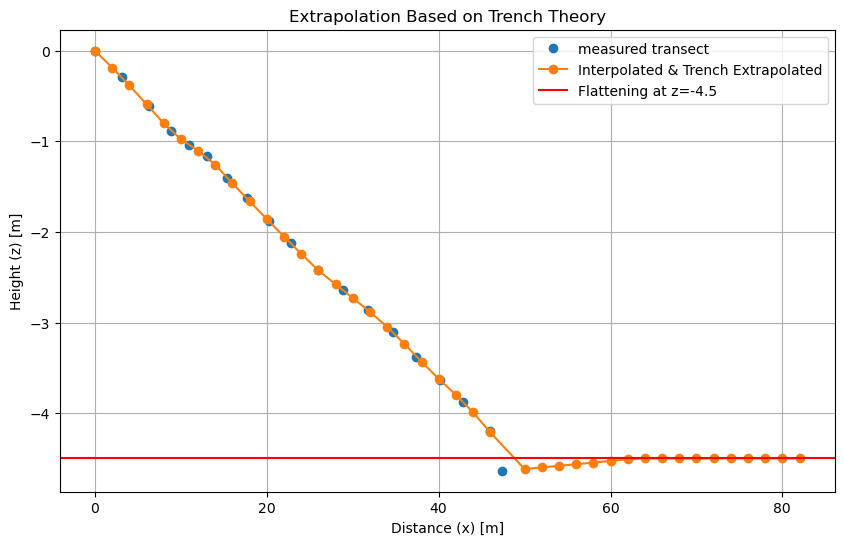

In [9]:
#extrapolation method 2
# Parameters for the new extrapolation
depth_point = z[-1]  # Last known depth
rise_height = -4.5  # Target flattening height
rise_distance = 15  # Distance over which to rise to the target height

# Compute the new extrapolation
def trench_extrapolation(x, depth_point, rise_height, rise_distance):
    # Linear rise from the last point to the rise height
    if x < (int_end + rise_distance):
        return depth_point + (rise_height - depth_point) / rise_distance * (x - int_end)
    else:
        return rise_height

z_extrap = np.array([trench_extrapolation(x, depth_point, rise_height, rise_distance) for x in x_extrap])

# Combine interpolated and extrapolated x and z values
x_total = np.concatenate([x_interp, x_extrap])
z_total = np.concatenate([z_interp, z_extrap])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(dist, z, 'o', label='measured transect')
plt.plot(x_total, z_total, marker = 'o', label='Interpolated & Trench Extrapolated')
plt.axhline(-4.5, color='r', label='Flattening at z=-4.5')
plt.xlabel('Distance (x) [m]')
plt.ylabel('Height (z) [m]')
plt.title('Extrapolation Based on Trench Theory')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
print(z_total)

[ 0.         -0.18758159 -0.38370733 -0.590561   -0.80080264 -0.97669932
 -1.10375884 -1.25864912 -1.46439684 -1.66200314 -1.8579279  -2.05172139
 -2.24046235 -2.4251348  -2.57685428 -2.72880753 -2.88227605 -3.04705463
 -3.23457282 -3.43131097 -3.62069085 -3.79753454 -3.99192865 -4.21101541
 -4.617      -4.599      -4.581      -4.563      -4.545      -4.527
 -4.509      -4.5        -4.5        -4.5        -4.5        -4.5
 -4.5        -4.5        -4.5        -4.5        -4.5       ]


In [11]:
print(len(z_total))

41


In [12]:
#rectified z for mean sea level (input matlab)

z_rectified = z_total + 0.204 + 3.6
# z_rectified = []

# for i in range(len(z_total)):
#     z_rectified.append(z_total[i] + 0.204 + 3.6)

print(z_rectified)

[ 3.804       3.61641841  3.42029267  3.213439    3.00319736  2.82730068
  2.70024116  2.54535088  2.33960316  2.14199686  1.9460721   1.75227861
  1.56353765  1.3788652   1.22714572  1.07519247  0.92172395  0.75694537
  0.56942718  0.37268903  0.18330915  0.00646546 -0.18792865 -0.40701541
 -0.813      -0.795      -0.777      -0.759      -0.741      -0.723
 -0.705      -0.696      -0.696      -0.696      -0.696      -0.696
 -0.696      -0.696      -0.696      -0.696      -0.696     ]
